# Importing Libraries

In [ ]:
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToPILImage

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

from scipy import linalg

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mounting Drive

In [ ]:
if ('google' in str(get_ipython())):
    from google.colab import drive
    drive.mount('ME')
    predir='ME/My Drive/'
else:
    predir='/Users/amit/Google Drive/'

datadir = predir + 'LSDA_data/mnist/'

Mounted at ME


# Getting and Preprocessing Data

In [ ]:
def get_mnist():
    data = np.float64(np.load(datadir + 'MNIST_data.npy'))
    labels = np.float32(np.load(datadir + 'MNIST_labels.npy'))

    return data, labels

In [ ]:
def preprocess_mnist(data):
    return data / 255

In [ ]:
def train_val_test_split(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=69)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=420)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def get_random_subset_of_data(X,y, percent=None, n_samples = None):
    n = len(X)
    if n_samples is None:
        n_samples = int(n * percent)

    random_indices = random.sample(range(n), k=n_samples)
    new_X = X[random_indices]
    new_y = y[random_indices]

    return new_X, new_y

In [ ]:
def convert_X_to_tensor(X):
    return torch.from_numpy(X).float().to(device)

# Defining the Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, s, h, d):
        """
        s  - input size
        h  - output size of linear layer
        d  - size of embedding (actually, embidding size is 2d for mean and var)
        lr - learning rate
        """
        super(Encoder, self).__init__()

        self.linear = nn.Linear(in_features = s, out_features = h)
        self.embedding = nn.Linear(in_features = h, out_features = 2*d)

    def forward(self, x):
        return self.embedding(F.relu(self.linear(x)))

# Defining the Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, s, h, d):
        """
        s  - output size
        h  - output size of linear layer
        d  - size of embedding layer
        """
        super(Decoder, self).__init__()

        self.linear = nn.Linear(in_features = d, out_features = h)
        self.output = nn.Linear(in_features = h, out_features = s)

    def forward(self, x):
        O = F.sigmoid(self.output(F.relu(self.linear(x))))
        return torch.clamp(O, min=0, max=1)


# Defining the Variational Autoencoder

In [ ]:
class VAE(nn.Module):
    def __init__(self, s, h, d, device):
        """
        s  - input size
        h  - output of linear layer
        d  - size of embedding
        """
        super(VAE, self).__init__()

        self.s = s
        self.h = h
        self.d = d
        self.device = device

        self.encoder = Encoder(s,h,d).to(device)
        self.decoder = Decoder(s,h,d).to(device)

        self.classifier = None

    def forward(self, x):
        embedding = self.encoder(x)

        mean = embedding[:,:self.d]
        log_std = embedding[:,self.d:]

        Z = mean + torch.exp(log_std) * torch.randn_like(log_std)

        output = self.decoder(Z)
        return output, mean, log_std

    def get_loss(self, x, x_hat, mean, log_std):
        BCE = F.binary_cross_entropy(x_hat, x, reduction='sum')
        KL_divergence = 0.5 * torch.sum(1 + 2* log_std - mean.pow(2) - log_std.exp().pow(2))

        return BCE - KL_divergence

    def reconstruct_images(self, images, plot = True):
        new_images = convert_X_to_tensor(images)

        embedding = self.encoder(new_images)
        mean = embedding[:,:self.d]
        log_std = embedding[:,self.d:]

        Z = mean + torch.exp(log_std) * torch.randn_like(log_std)

        reconstructed_images = self.decoder(Z)

        if plot:
            n_rows = int(len(images)/2)
            n_cols = 4

            fig, axs = plt.subplots(n_rows, n_cols, figsize = (8,2.5 * n_rows))

            for i in range(len(images)):
                for j in range(2):
                    row = int(i/2)
                    col = 2*(i % 2) + j
                    if j == 0:
                        img = images[i].reshape(28,28)
                        axs[row][col].imshow(img, cmap = "gray")
                        axs[row][col].set_title("Original")
                    else:
                        img = reconstructed_images[i].reshape(28,28).detach().numpy()
                        axs[row][col].imshow(img, cmap = "gray")
                        axs[row][col].set_title("Reconstruction")

            plt.show()

        else:
            return reconstructed_images

    def generate_samples(self, n_samples = 100, plot = True):
        random_samples = torch.randn(n_samples,self.d)
        generated_samples = self.decoder(random_samples)

        if plot:
            fig, axs = plt.subplots(10, 10, figsize = (16,16))

            for i in range(10):
                for j in range(10):
                    img = generated_samples[10 * i + j].reshape(28,28).detach().numpy()
                    axs[i][j].imshow(img, cmap = "gray")

            plt.show()
        else:
            return generated_samples

    def compute_Qk(self, X, k):
        embeddings = self.encoder(X)
        means, log_std = embeddings[:,:self.d], embeddings[:,self.d:]

        std = torch.exp(0.5 * log_std)

        means = means.unsqueeze(1).repeat(1,k,1)
        std = std.unsqueeze(1).repeat(1,k,1)

        standard_normals = torch.rand_like(means)
        zs = means + std * standard_normals

        X_ext = X.unsqueeze(1).repeat(1,k,1)
        output = self.decoder(zs)

        log_bernoulli = -nn.BCELoss(reduction = 'none')(output, X_ext).sum(axis = 2)
        log_gauss = -0.5 * (((zs - means) / std).pow(2) - zs.pow(2)) - torch.log(std)

        log_gauss = torch.sum(log_gauss, axis = 2)

        res = log_bernoulli + log_gauss - torch.log(torch.tensor([k]))
        Q_vec = torch.logsumexp(res, dim = 1)

        Q_avg = torch.mean(Q_vec)

        return Q_vec, Q_avg

    def train_SVC_classifier(self, X, y):
        embeddings = self.encoder(X)

        classifier = SVC()
        classifier.fit(embeddings.detach().numpy(), y)

        self.classifier = classifier

    def classify_SVC(self, X):
        embeddings = self.encoder(X)

        return self.classifier.predict(embeddings.detach().numpy())


# Training the VAE

In [ ]:
def train_vae(s, h, d, lr, batch_size, epochs, X_train, X_val, verbose=True):
    """
    s           - input size
    h           - output of linear layer
    d           - size of embedding
    lr          - learning rate
    batch_size  - batch size
    epochs      - number of epochs
    """

    model = VAE(s, h, d, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train = convert_X_to_tensor(X_train)
    X_val = convert_X_to_tensor(X_val)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for i in range(int(len(X_train) / batch_size)):
            X = X_train[i * batch_size: (i+1) * batch_size]
            y = y_train[i * batch_size: (i+1) * batch_size]

            # Forward pass
            optimizer.zero_grad()
            out, mean, log_std = model(X)

            # Compute loss
            loss = model.get_loss(X, out, mean, log_std)

            # Backward pass and optimization
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        if verbose:
            train_out, train_mean, train_log_std = model(X_train)
            train_loss = model.get_loss(X_train, train_out, train_mean, train_log_std)

            val_out, val_mean, val_log_std = model(X_val)
            val_loss = model.get_loss(X_val, val_out, val_mean, val_log_std)

            print(f"Epoch: {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

    return model

# Getting Data and First Training of VAE

In [ ]:
data, labels = get_mnist()
data = preprocess_mnist(data)
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(data, labels)

In [ ]:
vae_model = train_vae(s=784, h=1024, d=40, lr=0.001, batch_size=1000, epochs=20, X_train=X_train, X_val=X_val)

Epoch: 1, Training Loss: 8434497.0, Validation Loss: 2813563.0
Epoch: 2, Training Loss: 7094451.0, Validation Loss: 2372258.75
Epoch: 3, Training Loss: 6413671.5, Validation Loss: 2145385.25
Epoch: 4, Training Loss: 5976631.5, Validation Loss: 2000876.5
Epoch: 5, Training Loss: 5655881.0, Validation Loss: 1893447.0
Epoch: 6, Training Loss: 5410539.0, Validation Loss: 1811012.625
Epoch: 7, Training Loss: 5246140.0, Validation Loss: 1758561.5
Epoch: 8, Training Loss: 5113936.0, Validation Loss: 1712197.375
Epoch: 9, Training Loss: 5009003.0, Validation Loss: 1678972.0
Epoch: 10, Training Loss: 4923030.0, Validation Loss: 1651205.625
Epoch: 11, Training Loss: 4867177.5, Validation Loss: 1631747.625
Epoch: 12, Training Loss: 4792575.0, Validation Loss: 1607205.25
Epoch: 13, Training Loss: 4742741.5, Validation Loss: 1591593.25
Epoch: 14, Training Loss: 4708085.5, Validation Loss: 1581623.0
Epoch: 15, Training Loss: 4661881.0, Validation Loss: 1565773.375
Epoch: 16, Training Loss: 4642329.0

# Saving and Loading the Model

In [ ]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(path, s, h, d, device):
    model = VAE(s, h, d, device)
    model.load_state_dict(torch.load(path))
    model.eval()

    return model

In [ ]:
path = predir + 'LSDA_data/models/'

save_model(vae_model, path + 'first_model.pt')

In [ ]:
path = predir + 'LSDA_data/models/'

vae_model = load_model(path=path + 'first_model.pt', s=784, h=1024, d=40, device=device)

# Reconstructing 10 Random Images From the Test Set

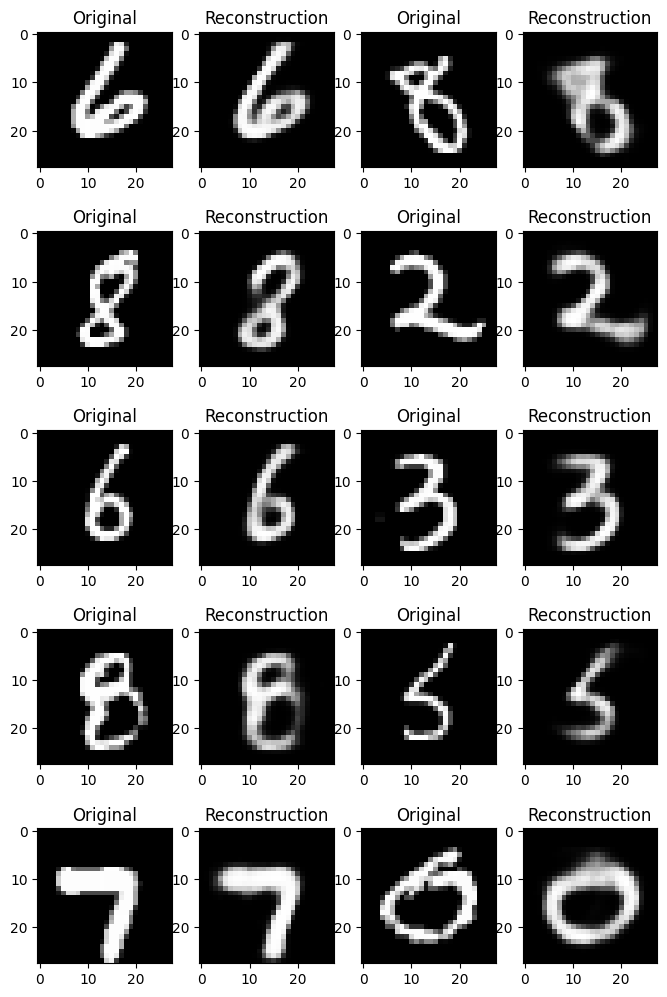

In [ ]:
test_sample, _ = get_random_subset_of_data(X_test, y_test, n_samples = 10)
_ = vae_model.reconstruct_images(test_sample)

# Generating 100 Samples

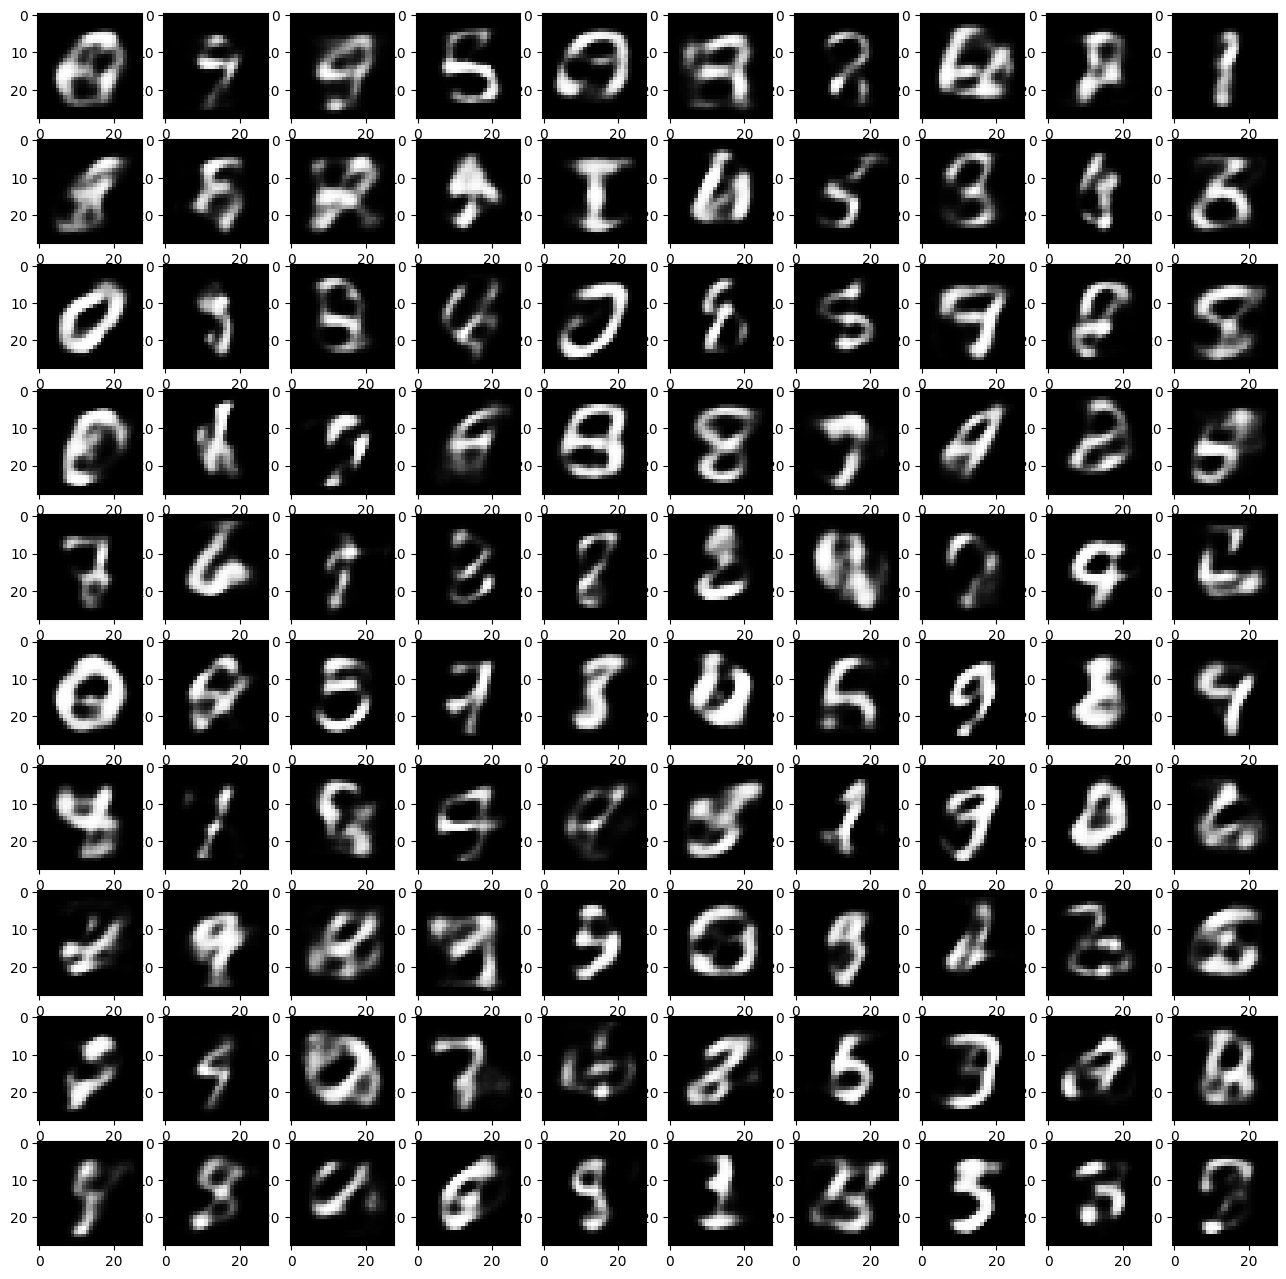

In [ ]:
vae_model.generate_samples()

# Calculate FID score

In [ ]:
def calculate_FID_score(model, X_train):
    generated_samples = model.generate_samples(n_samples = 2000, plot = False)
    generated_samples = generated_samples.detach().numpy()

    mu_X = np.mean(X_train, axis = 0)
    mu_Y = np.mean(generated_samples, axis = 0)

    Sigma_X = np.cov(X_train, rowvar = False)
    Sigma_Y = np.cov(generated_samples, rowvar = False)

    eigenvalues_X, U_X = np.linalg.eigh(Sigma_X)
    eigenvalues_Y, U_Y = np.linalg.eigh(Sigma_Y)

    # some eigenvalues are very slightly negative (lowest one is about -1*e-16)
    # we set them to 0 to ensure we can take their square root
    eigenvalues_X[eigenvalues_X < 0] = 0
    eigenvalues_Y[eigenvalues_Y < 0] = 0

    eigenvalues_X = np.sqrt(eigenvalues_X)
    eigenvalues_Y = np.sqrt(eigenvalues_Y)

    sqrt_Sigma_X = np.dot(np.dot(U_X, np.diag(eigenvalues_X)), U_X.T)
    sqrt_Sigma_Y = np.dot(np.dot(U_Y, np.diag(eigenvalues_Y)), U_Y.T)

    diff = mu_X - mu_Y
    fid_score = np.dot(diff, diff) + np.trace(Sigma_X + Sigma_Y - 2 * np.dot(sqrt_Sigma_Y, sqrt_Sigma_X))

    return fid_score, mu_X, mu_Y, Sigma_X, Sigma_Y

# Testing Different Parameters and Saving the Models

In [ ]:
class VAE_Candidate:
    def __init__(self, d, h, n_parameters, val_loss, fid_score, model):
        self.d = d
        self.h = h
        self.n_parameters = n_parameters
        self.val_loss = val_loss
        self.fid_score = fid_score
        self.model = model

In [ ]:
"""Takes around 20 minutes to run"""
vae_candidates = []

for d in [10,20,40]:
    for h in [256, 512, 1024]:
        vae_model = train_vae(s=784, h=h, d=d, lr=0.001, batch_size=1000,epochs=20,
                              X_train=X_train, X_val=X_val, verbose = False)

        _X_val = convert_X_to_tensor(X_val)
        val_out, val_mean, val_log_std = vae_model(_X_val)
        val_loss = vae_model.get_loss(_X_val, val_out, val_mean, val_log_std)

        fid_score, _, _, _, _ = calculate_FID_score(vae_model, X_train)
        n_parameters = sum(p.numel() for p in vae_model.parameters())

        print(f"d: {d}, h: {h}, val_loss: {val_loss}, FID score: {fid_score}")

        vae_candidate = VAE_Candidate(d, h, n_parameters, val_loss, fid_score, vae_model)
        vae_candidates.append(vae_candidate)

d: 10, h: 256, val_loss: 1697160.5, FID score: 12.748163077805305
d: 10, h: 512, val_loss: 1637549.625, FID score: 11.156171527259229
d: 10, h: 1024, val_loss: 1583601.25, FID score: 10.584881977088843
d: 20, h: 256, val_loss: 1633808.0, FID score: 9.350567516740965
d: 20, h: 512, val_loss: 1558626.875, FID score: 8.214546874556873
d: 20, h: 1024, val_loss: 1510938.75, FID score: 7.029328877246728
d: 40, h: 256, val_loss: 1660834.875, FID score: 9.814336969278893
d: 40, h: 512, val_loss: 1576248.0, FID score: 8.339616630132255
d: 40, h: 1024, val_loss: 1527616.375, FID score: 7.200384614798164


# Plotting Validation Loss Against FID Score

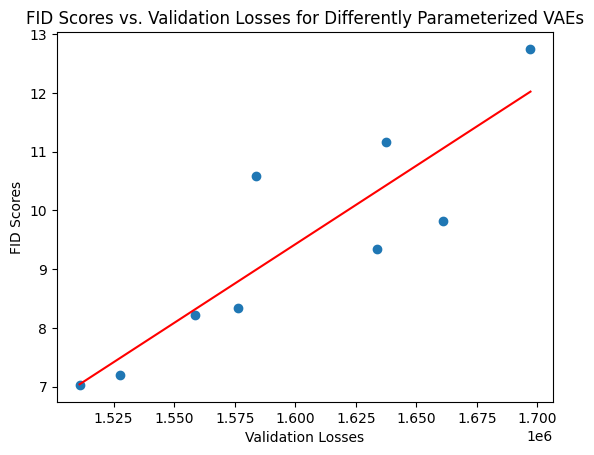

In [ ]:
val_losses = [model.val_loss.detach().numpy() for model in vae_candidates]
fid_scores = [model.fid_score for model in vae_candidates]

slope, intercept = np.polyfit(val_losses, fid_scores, 1)

x_line = np.linspace(np.min(val_losses), np.max(val_losses), 100)
y_line = slope * x_line + intercept

plt.scatter(val_losses, fid_scores)
plt.plot(x_line, y_line, color='red')
plt.xlabel('Validation Losses')
plt.ylabel('FID Scores')
plt.title('FID Scores vs. Validation Losses for Differently Parameterized VAEs')
plt.show()

We can see a clear correlation between the Validation Losses and the FID score, meaning that as the validation loss decreases, the FID score decreases as well. This gives us a strong argument as for why FID scores give a good indication of the accuracy of a generative model.

# Saving and Loading the 3 Best Models

In [ ]:
path = predir + 'LSDA_data/models/'

save_model(vae_candidates[5].model, path + 'd_20_h_1024.pt')
save_model(vae_candidates[7].model, path + 'd_40_h_512.pt')
save_model(vae_candidates[8].model, path + 'd_40_h_1024.pt')

In [ ]:
best_models = []
path = predir + 'LSDA_data/models/'

best_models.append(load_model(path=path + 'd_20_h_1024.pt', s=784, h=1024, d=20, device=device))
best_models.append(load_model(path=path + 'd_40_h_512.pt', s=784, h=512, d=40, device=device))
best_models.append(load_model(path=path + 'd_40_h_1024.pt', s=784, h=1024, d=40, device=device))

# Running Q_k Computation on Saved Models for Different k

In [ ]:
Qs = [[] for _ in range(3)]

for i, model in enumerate(best_models):
    val_sample, _ = get_random_subset_of_data(X_val, y_val, n_samples = 100)
    for k in [3, 5, 10, 50, 100, 200, 500, 1000]:
        _, Q_avg = model.compute_Qk(convert_X_to_tensor(val_sample), k)
        Qs[i].append(-Q_avg.detach().numpy())

        print(f'model: {i+1}, k: {k}, -Q_k: {-Q_avg}')

model: 1, k: 3, -Q_k: 64.7521743774414
model: 1, k: 5, -Q_k: 63.991390228271484
model: 1, k: 10, -Q_k: 63.6224250793457
model: 1, k: 50, -Q_k: 62.749568939208984
model: 1, k: 100, -Q_k: 62.502418518066406
model: 1, k: 200, -Q_k: 62.44677734375
model: 1, k: 500, -Q_k: 62.3790283203125
model: 1, k: 1000, -Q_k: 62.33079147338867
model: 2, k: 3, -Q_k: 60.65096664428711
model: 2, k: 5, -Q_k: 60.45928192138672
model: 2, k: 10, -Q_k: 59.972599029541016
model: 2, k: 50, -Q_k: 59.05137634277344
model: 2, k: 100, -Q_k: 58.620548248291016
model: 2, k: 200, -Q_k: 58.503028869628906
model: 2, k: 500, -Q_k: 58.52729415893555
model: 2, k: 1000, -Q_k: 58.447715759277344
model: 3, k: 3, -Q_k: 62.25579071044922
model: 3, k: 5, -Q_k: 61.183250427246094
model: 3, k: 10, -Q_k: 61.01271057128906
model: 3, k: 50, -Q_k: 59.88694381713867
model: 3, k: 100, -Q_k: 59.5102653503418
model: 3, k: 200, -Q_k: 59.34723663330078
model: 3, k: 500, -Q_k: 59.172508239746094
model: 3, k: 1000, -Q_k: 59.134498596191406


# Plotting the Q_k's for each Model

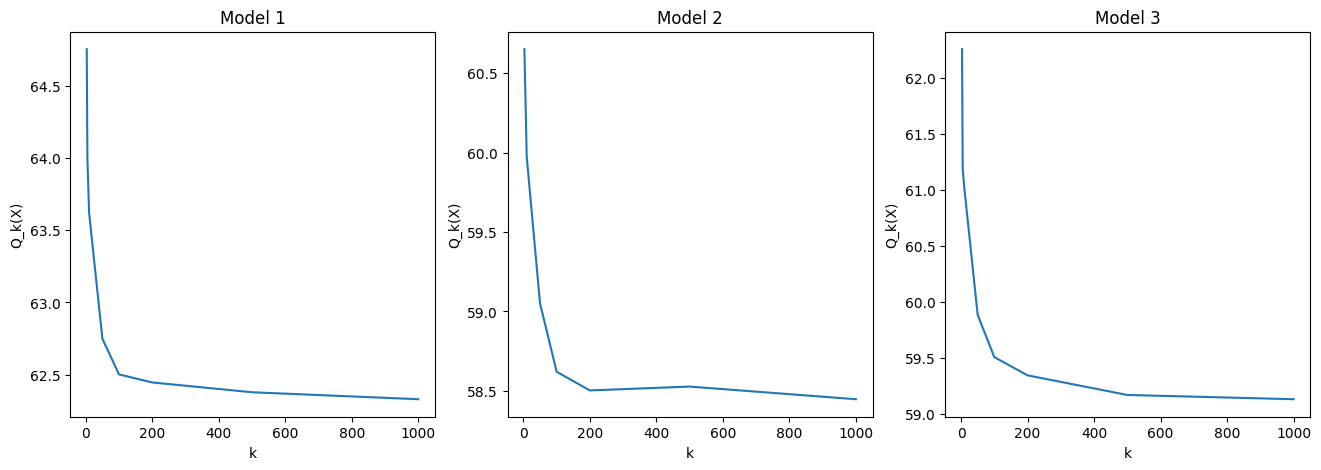

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (16,5))

for i in range(3):
    axs[i].plot([3, 5, 10, 50, 100, 200, 500, 1000], Qs[i])
    axs[i].set_xlabel('k')
    axs[i].set_ylabel('Q_k(X)')
    axs[i].set_title(f'Model {i+1}')

plt.show()

We can see that for low k, there is a larger difference between the Q_k's but for larger k this quickly drops off an becomes almost constant. Note that this is plotting -Q_k, and we can see that it decreases over time. Therefore, we have good reason to suspect that the Q_k's converge.

# Classification with the Embeddings

In [ ]:
"""Takes around 10 minutes to run"""
new_candidates = []

for d in [10, 40, 80, 160]:
    vae_model = train_vae(s=784, h=512, d=d, lr=0.001, batch_size=1000,epochs=20,
                              X_train=X_train, X_val=X_val, verbose = False)

    _X_val = convert_X_to_tensor(X_val)
    val_out, val_mean, val_log_std = vae_model(_X_val)
    val_loss = vae_model.get_loss(_X_val, val_out, val_mean, val_log_std)

    fid_score, _, _, _, _ = calculate_FID_score(vae_model, X_train)
    n_parameters = sum(p.numel() for p in vae_model.parameters())

    print(f"d: {d}, h: {512}, val_loss: {val_loss}, FID score: {fid_score}")

    vae_candidate = VAE_Candidate(d, 512, n_parameters, val_loss, fid_score, vae_model)
    new_candidates.append(vae_candidate)

d: 10, h: 1024, val_loss: 1633258.625, FID score: 10.97912045866633
d: 40, h: 1024, val_loss: 1571377.25, FID score: 8.242831043557457
d: 80, h: 1024, val_loss: 1579651.875, FID score: 8.482032628022063
d: 160, h: 1024, val_loss: 1604006.75, FID score: 9.304093538950129


In [ ]:
embedding_accuracies = {0: [], 1: [], 2: [], 3: []}
standard_accuracies = []

for n_train_samples in [50, 100, 200, 500, 1000, 2000, 5000]:
    print(f'Number of Training Samples: {n_train_samples}')
    train_samples, train_labels = get_random_subset_of_data(X_train, y_train, n_samples=n_train_samples)
    train_samples_torch = convert_X_to_tensor(train_samples)

    for i, candidate in enumerate(new_candidates):
        model = candidate.model

        model.train_SVC_classifier(train_samples_torch, train_labels)
        embedding_pred = model.classify_SVC(convert_X_to_tensor(X_test))

        embedding_accuracy = metrics.accuracy_score(y_test, embedding_pred)
        embedding_accuracies[i].append(embedding_accuracy)
        print(f'model: (d={candidate.d}, h=512), accuracy (embedding classifier): {embedding_accuracy}')

    standard_classifier = SVC(gamma=0.001)
    standard_classifier.fit(train_samples, train_labels)
    standard_pred = standard_classifier.predict(X_test)

    standard_accuracy = metrics.accuracy_score(y_test, standard_pred)
    standard_accuracies.append(standard_accuracy)
    print(f'accuracy (standard classifier): {standard_accuracy}')
    print()

Number of Training Samples: 50
model: (d=10, h=512), accuracy (embedding classifier): 0.6061428571428571
model: (d=40, h=512), accuracy (embedding classifier): 0.4495
model: (d=80, h=512), accuracy (embedding classifier): 0.4327857142857143
model: (d=160, h=512), accuracy (embedding classifier): 0.45671428571428574
accuracy (standard classifier): 0.11207142857142857

Number of Training Samples: 100
model: (d=10, h=512), accuracy (embedding classifier): 0.7885
model: (d=40, h=512), accuracy (embedding classifier): 0.7576428571428572
model: (d=80, h=512), accuracy (embedding classifier): 0.7743571428571429
model: (d=160, h=512), accuracy (embedding classifier): 0.769
accuracy (standard classifier): 0.20042857142857143

Number of Training Samples: 200
model: (d=10, h=512), accuracy (embedding classifier): 0.8423571428571428
model: (d=40, h=512), accuracy (embedding classifier): 0.8409285714285715
model: (d=80, h=512), accuracy (embedding classifier): 0.8405
model: (d=160, h=512), accuracy

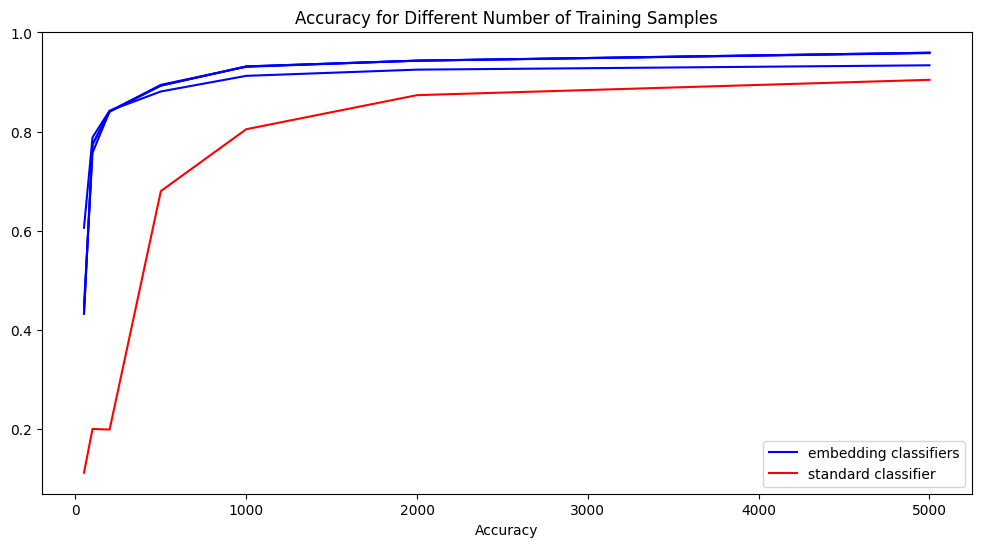

In [ ]:
n_train_samples = [50, 100, 200, 500, 1000, 2000, 5000]

fig, ax = plt.subplots(figsize = (12,6))

for i in range(3):
    ax.plot(n_train_samples, embedding_accuracies[i], color = 'blue')

ax.plot(n_train_samples, embedding_accuracies[i], color = 'blue', label = 'embedding classifiers')
ax.plot(n_train_samples, standard_accuracies, color = 'red', label = 'standard classifier')
ax.set_xlabel('Number of Training Samples')
ax.set_xlabel('Accuracy')
ax.set_title('Accuracy for Different Number of Training Samples')
ax.legend(loc='lower right')

plt.show()


Above we see a plot of the accuracies for different number of *labeled* training samples. Note that the embedding classifiers (i.e. the classifiers that train on the embedding of variational autoencoders) have already been trained on the whole training dataset to generate the embeddings, but they have the same number of labeled training data. We can see that the embedding classifiers perform much better with a low number of labeled training data, and while the standard classifier catches up somewhat once we have more labeled data, it still can't match the embedding classifiers. This suggests that, if we don't have a lot of labeled data, we should run a variational autoencoder on the unlabeled data to generate embeddings and the perform classification on those embeddings rather than on the original sample space.

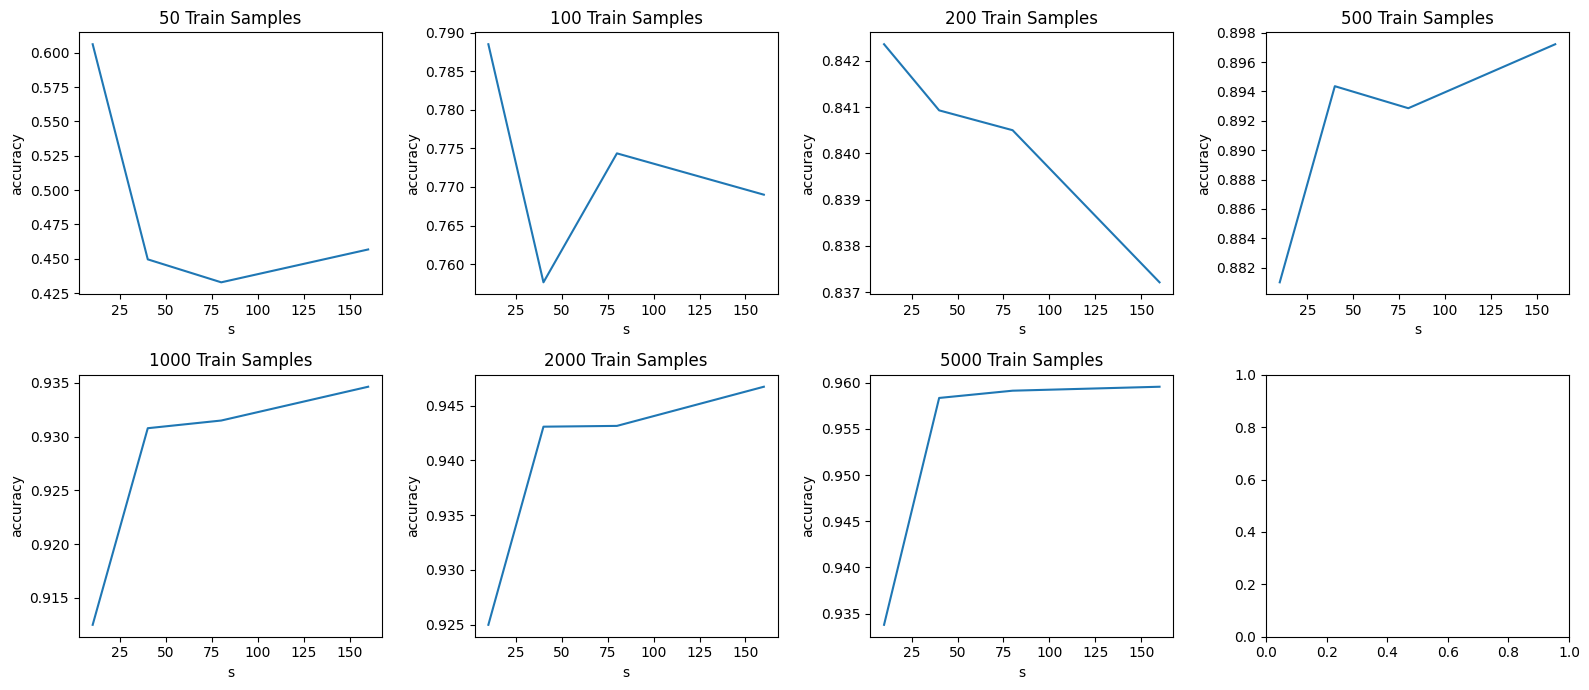

In [ ]:
ss = [10,40,80,160]

fig, axs = plt.subplots(2, 4, figsize = (16,7))

for i in range(len(n_train_samples)):
    row, col = int(i / 4), i % 4
    accuracies = [embedding_accuracies[j][i] for j in range(4)]
    axs[row][col].plot(ss, accuracies)
    axs[row][col].set_xlabel('s')
    axs[row][col].set_ylabel('accuracy')
    axs[row][col].set_title(f'{n_train_samples[i]} Train Samples')

plt.tight_layout()
plt.show()

Above we see plots that show the accuracy for each of the 4 models (where s is the dimension of the embedding layer, or rather 2s) for different number of training samples. We can see that for low number of training samples, the models with a lower dimensional embedding space perofrm better, but once we get past 500 training samples the models with a higher dimensional embedding space perform better.

# Classification with Generative Models

In [ ]:
def split_dataset_into_digits(X,y):
    digit_datasets = {}

    for digit in range(10):
        digit_images = X[y == digit]
        digit_labels = y[y == digit]

        digit_datasets[digit] = (digit_images, digit_labels)

    return digit_datasets

In [ ]:
def train_model_per_digit(train_data, val_data, h, d):
    models = []

    for i in range(10):
        vae_model = train_vae(s=784, h=h, d=d, lr=0.001, batch_size=100, epochs=20,
                              X_train=train_data[i][0], X_val=val_data[i][0], verbose=False)

        _X_val = convert_X_to_tensor(val_data[i][0])
        val_out, val_mean, val_log_std = vae_model(_X_val)
        val_loss = vae_model.get_loss(_X_val, val_out, val_mean, val_log_std)

        print(f"digit: {i}, val_loss: {val_loss}")

        models.append(vae_model)

    return models

In [ ]:
def classify_using_Qk(models, k, X_test):
    Q_vecs = []
    for model in models:
        Q_vec, Q_avg = model.compute_Qk(X_test, k)
        Q_vecs.append(Q_vec.detach().numpy())

    Q_vecs = np.array(Q_vecs)
    preds = np.argmax(Q_vecs.T, axis=1)

    return preds, Q_vecs.T

We train 10 variational autoencoders, one for each digit. We use an altered dataset that is split according to the corresponding labels. Note that the training of the autoencoders doesn't actually use the labels, it just uses the fact that all the inputs "look the same." Then, when classifying, we calculate Q_k for each of the 10 models and predict the digit whose respective model produced the largest value for Q_k.

In [ ]:
digit_datasets_train = split_dataset_into_digits(X_train, y_train)
digit_datasets_val = split_dataset_into_digits(X_val, y_val)

models = train_model_per_digit(digit_datasets_train, digit_datasets_val, h=512, d=30)

digit: 0, val_loss: 162495.609375
digit: 1, val_loss: 79857.8046875
digit: 2, val_loss: 173030.109375
digit: 3, val_loss: 172858.1875
digit: 4, val_loss: 140593.546875
digit: 5, val_loss: 148489.4375
digit: 6, val_loss: 135850.90625
digit: 7, val_loss: 133995.734375
digit: 8, val_loss: 169152.921875
digit: 9, val_loss: 135369.6875


In [ ]:
test_samples, test_labels = get_random_subset_of_data(X_test,y_test, n_samples = 300)
preds = classify_using_Qk(models, 10, convert_X_to_tensor(test_samples))

accuracy = metrics.accuracy_score(preds[0], test_labels)
print(f'Accuracy using k=10: {accuracy}')
print()

preds = classify_using_Qk(models, 100, convert_X_to_tensor(test_samples))
accuracy = metrics.accuracy_score(preds[0], test_labels)
print(f'Accuracy using k=100: {accuracy}')
print()

Accuracy using k=10: 0.95

Accuracy using k=100: 0.9466666666666667



Above we classified 300 test samples using this generative method of classification, once with k=10 and once with k=100. Note that the reason why only 300 test samples were used to test the accuracy is that this is an expensive operation (the RAM got filled up really quickly if I used more testing samples). We can see that this is an improvement over the EM classification we did in Homework 4, where I got around 89% accuracy.